# Backend - additive

> Additive SAX Backend

Sometimes we would like to calculate circuit path lengths or time delays within a circuit. We could obviously simulate these things with a time domain simulator, but in many cases a simple additive backend (as opposed to the default multiplicative backend) can suffice.

In [2]:
import os, sys; sys.stderr = open(os.devnull, "w")

In [3]:
from __future__ import annotations

from typing import Dict, Tuple

import networkx as nx
from sax.typing_ import SDict, SType, sdict

try:
    import jax.numpy as jnp
    JAX_AVAILABLE = True
except ImportError:
    import numpy as jnp
    JAX_AVAILABLE = False

:::{eval-rst}
.. autofunction:: sax.backends.additive.split_port
:::


In [4]:
def split_port(port: str) -> Tuple[str, str]:
    try:
        instance, port = port.split(",")
    except ValueError:
        (port,) = port.split(",")
        instance = ""
    return instance, port

In [5]:
assert split_port("wg,in0") == ('wg', 'in0') # internal circuit port
assert split_port("out0") == ('', 'out0') # external circuit port

:::{eval-rst}
.. autofunction:: sax.backends.additive.graph_edges
:::


In [6]:
def graph_edges(
    instances: Dict[str, SType], connections: Dict[str, str], ports: Dict[str, str]
):
    zero = jnp.array([0.0], dtype=float)
    edges = {}
    edges.update({split_port(k): split_port(v) for k, v in connections.items()})
    edges.update({split_port(v): split_port(k) for k, v in connections.items()})
    edges.update({split_port(k): split_port(v) for k, v in ports.items()})
    edges.update({split_port(v): split_port(k) for k, v in ports.items()})
    edges = [(n1, n2, {"type": "C", "length": zero}) for n1, n2 in edges.items()]

    _instances = {
        **{i1: None for (i1, _), (_, _), _ in edges},
        **{i2: None for (_, _), (i2, _), _ in edges},
    }
    del _instances[""] # external ports don't belong to an instance

    for instance in _instances:
        s = instances[instance]
        edges += [
            ((instance, p1), (instance, p2), {"type": "S", "length": jnp.asarray(length, dtype=float).ravel()})
            for (p1, p2), length in sdict(s).items()
        ]

    return edges

> Example

> Note: in stead of S-parameters the stypes need to contain *additive* parameters, such as length or time delay.

In [7]:
wg_sdict = {
    ("in0", "out0"): jnp.array([100.0, 200.0, 300.0]), # assume for now there are three possible paths between these two ports.
    ("out0", "in0"): jnp.array([100.0, 200.0, 300.0]), # assume for now there are three possible paths between these two ports.
}

dc_sdict = {
    ("in0", "out0"): jnp.array([10.0, 20.0]), # assume for now there are two possible paths between these two ports.
    ("in0", "out1"): 15.0,
    ("in1", "out0"): 15.0,
    ("in1", "out1"): jnp.array([10.0, 20.0]), # assume for now there are two possible paths between these two ports.
}

instances= {
    "dc1": dc_sdict,
    "wg": wg_sdict,
    "dc2": dc_sdict,
}
connections= {
    "dc1,out0": "wg,in0",
    "wg,out0": "dc2,in0",
    "dc1,out1": "dc2,in1",
}
ports= {
    "in0": "dc1,in0",
    "in1": "dc1,in1",
    "out0": "dc2,out0",
    "out1": "dc2,out1",
}

> Note: it is recommended to **not** use an `SDense` representation for the additive backend. Very often an `SDense` representation will introduce **zeros** which will be interpreted as an **existing connection with zero length**. Conversely, in a sparse representation like `SDict` or `SCoo`, non-existing elements will be just that: they will not be present in the internal graph.

In [8]:
edges = graph_edges(instances, connections, ports)
edges

[(('dc1', 'out0'),
  ('wg', 'in0'),
  {'type': 'C', 'length': Array([0.], dtype=float64)}),
 (('wg', 'out0'),
  ('dc2', 'in0'),
  {'type': 'C', 'length': Array([0.], dtype=float64)}),
 (('dc1', 'out1'),
  ('dc2', 'in1'),
  {'type': 'C', 'length': Array([0.], dtype=float64)}),
 (('wg', 'in0'),
  ('dc1', 'out0'),
  {'type': 'C', 'length': Array([0.], dtype=float64)}),
 (('dc2', 'in0'),
  ('wg', 'out0'),
  {'type': 'C', 'length': Array([0.], dtype=float64)}),
 (('dc2', 'in1'),
  ('dc1', 'out1'),
  {'type': 'C', 'length': Array([0.], dtype=float64)}),
 (('', 'in0'),
  ('dc1', 'in0'),
  {'type': 'C', 'length': Array([0.], dtype=float64)}),
 (('', 'in1'),
  ('dc1', 'in1'),
  {'type': 'C', 'length': Array([0.], dtype=float64)}),
 (('', 'out0'),
  ('dc2', 'out0'),
  {'type': 'C', 'length': Array([0.], dtype=float64)}),
 (('', 'out1'),
  ('dc2', 'out1'),
  {'type': 'C', 'length': Array([0.], dtype=float64)}),
 (('dc1', 'in0'),
  ('', 'in0'),
  {'type': 'C', 'length': Array([0.], dtype=float64)}

We made a difference here between edges of 'S'-type (connections through the S-matrix) and edges of 'C'-type (connections through the connection matrix). Connections of 'C'-type obviously always have length zero as they signify per definition the equality of two ports.

We can create a NetworkX graph from these edges:

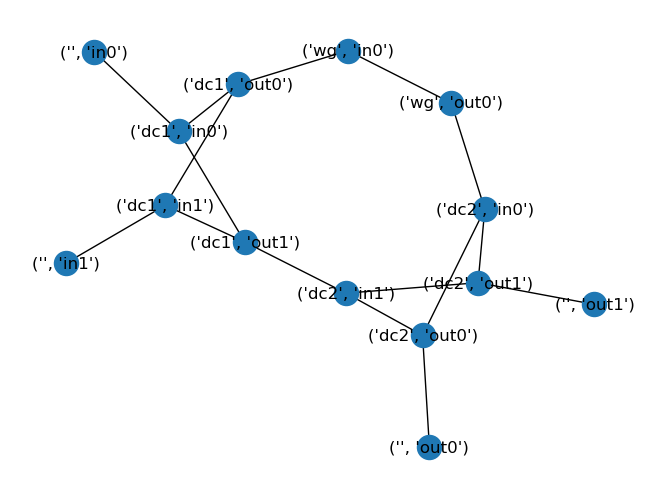

In [9]:
graph = nx.Graph()
graph.add_edges_from(edges)
nx.draw_kamada_kawai(graph, with_labels=True)

:::{eval-rst}
.. autofunction:: sax.backends.additive.prune_internal_output_nodes
:::


In [10]:
def prune_internal_output_nodes(graph):
    broken = True
    while broken:
        broken = False
        for (i, p), dic in list(graph.adjacency()):
            if (
                i != ""
                and len(dic) == 2
                and all(prop.get("type", "C") == "C" for prop in dic.values())
            ):
                graph.remove_node((i, p))
                graph.add_edge(*dic.keys(), type="C", length=0.0)
                broken = True
                break
    return graph

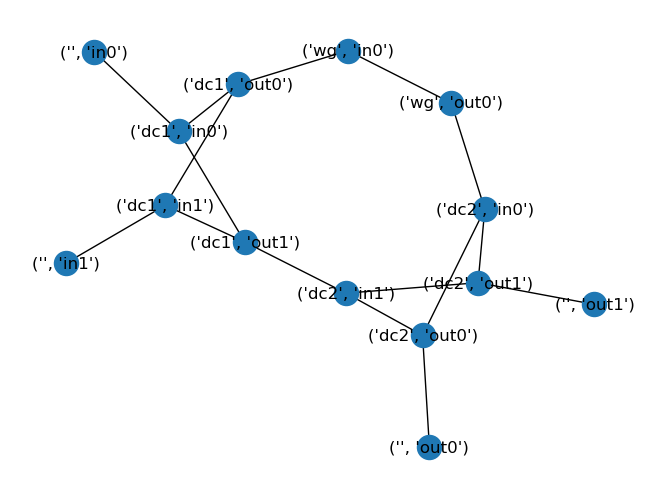

In [11]:
graph = prune_internal_output_nodes(graph)
nx.draw_kamada_kawai(graph, with_labels=True)

We can now get a list of all possible paths in the network. Note that these paths **must** alternate between an S-edge and a C-edge:

:::{eval-rst}
.. autofunction:: sax.backends.additive.get_possible_paths
:::


In [12]:
def get_possible_paths(graph, source, target):
    paths = []
    default_props = {"type": "C", "length": 0.0}
    for path in nx.all_simple_edge_paths(graph, source, target):
        prevtype = "C"
        for n1, n2 in path:
            curtype = graph.get_edge_data(n1, n2, default_props)["type"]
            if curtype == prevtype == "S":
                break
            else:
                prevtype = curtype
        else:
            paths.append(path)
    return paths

In [13]:
paths = get_possible_paths(graph, ("", "in0"), ("", "out0"))
paths

[[(('', 'in0'), ('dc1', 'in0')),
  (('dc1', 'in0'), ('dc1', 'out0')),
  (('dc1', 'out0'), ('wg', 'in0')),
  (('wg', 'in0'), ('wg', 'out0')),
  (('wg', 'out0'), ('dc2', 'in0')),
  (('dc2', 'in0'), ('dc2', 'out0')),
  (('dc2', 'out0'), ('', 'out0'))],
 [(('', 'in0'), ('dc1', 'in0')),
  (('dc1', 'in0'), ('dc1', 'out1')),
  (('dc1', 'out1'), ('dc2', 'in1')),
  (('dc2', 'in1'), ('dc2', 'out0')),
  (('dc2', 'out0'), ('', 'out0'))]]

And the path lengths of those paths can be calculated as follows:

:::{eval-rst}
.. autofunction:: sax.backends.additive.path_lengths
:::


In [14]:
def path_lengths(graph, paths):
    lengths = []
    for path in paths:
        length = zero = jnp.array([0.0], dtype=float)
        default_edge_data = {"type": "C", "length": zero}
        for edge in path:
            edge_data = graph.get_edge_data(*edge, default_edge_data)
            length = (length[None,:] + edge_data.get("length", zero)[:, None]).ravel()
        lengths.append(length)
    return lengths

In [15]:
path_lengths(graph, paths)

[Array([120., 130., 220., 230., 320., 330., 130., 140., 230., 240., 330.,
        340.], dtype=float64),
 Array([30.], dtype=float64)]

This is all brought together in the additive KLU backend:

:::{eval-rst}
.. autofunction:: sax.backends.additive.analyze_circuit_additive
:::


:::{eval-rst}
.. autofunction:: sax.backends.additive.evaluate_circuit_additive
:::


In [16]:
def analyze_circuit_additive(
    connections: Dict[str, str],
    ports: Dict[str, str],
):
    return connections, ports
    
def evaluate_circuit_additive(
    analyzed,
    instances: Dict[str, SDict],
):
    """evaluate a circuit for the given sdicts."""
    connections, ports = analyzed
    edges = graph_edges(instances, connections, ports)

    graph = nx.Graph()
    graph.add_edges_from(edges)
    prune_internal_output_nodes(graph)

    sdict = {}
    for source in ports:
        for target in ports:
            paths = get_possible_paths(graph, source=("", source), target=("", target))
            if not paths:
                continue
            sdict[source, target] = path_lengths(graph, paths)

    return sdict

In [17]:
evaluate_circuit_additive(analyze_circuit_additive(connections, ports), instances)

{('in0',
  'out0'): [Array([120., 130., 220., 230., 320., 330., 130., 140., 230., 240., 330.,
         340.], dtype=float64), Array([30.], dtype=float64)],
 ('in0', 'out1'): [Array([125., 135., 225., 235., 325., 335.], dtype=float64),
  Array([25., 35.], dtype=float64)],
 ('in1', 'out0'): [Array([125., 225., 325., 135., 235., 335.], dtype=float64),
  Array([25., 35.], dtype=float64)],
 ('in1', 'out1'): [Array([130., 230., 330.], dtype=float64),
  Array([20., 30., 30., 40.], dtype=float64)],
 ('out0',
  'in0'): [Array([120., 130., 220., 230., 320., 330., 130., 140., 230., 240., 330.,
         340.], dtype=float64), Array([30.], dtype=float64)],
 ('out0', 'in1'): [Array([125., 135., 225., 235., 325., 335.], dtype=float64),
  Array([25., 35.], dtype=float64)],
 ('out1', 'in0'): [Array([125., 225., 325., 135., 235., 335.], dtype=float64),
  Array([25., 35.], dtype=float64)],
 ('out1', 'in1'): [Array([130., 230., 330.], dtype=float64),
  Array([20., 30., 30., 40.], dtype=float64)]}